In [12]:
import sys
import time
import numpy as np
import pickle
from itertools import product
import gurobipy as gp
from gurobipy import GRB

In [13]:
n = 100
np.random.seed(1)
x_c = np.random.rand(n) * 100
y_c = np.random.rand(n) * 100
x_c, y_c = x_c.round(), y_c.round()

with open("x_{}.bin".format(n), 'wb') as file:
    pickle.dump(x_c, file)
with open("y_{}.bin".format(n), 'wb') as file:
    pickle.dump(y_c, file)

c = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        c[i, j] = np.sqrt((x_c[i] - x_c[j])**2 +(y_c[i] - y_c[j])**2).round()
print(x_c)
print(y_c)

[42. 72.  0. 30. 15.  9. 19. 35. 40. 54. 42. 69. 20. 88.  3. 67. 42. 56.
 14. 20. 80. 97. 31. 69. 88. 89.  9.  4. 17. 88. 10. 42. 96. 53. 69. 32.
 69. 83.  2. 75. 99. 75. 28. 79. 10. 45. 91. 29. 29. 13.  2. 68. 21. 27.
 49.  5. 57. 15. 59. 70. 10. 41. 69. 41.  5. 54. 66. 51. 94. 59. 90. 14.
 14. 81. 40. 17. 93. 35. 75. 73. 88. 62. 75. 35. 27. 90. 43. 96. 66. 62.
 11. 95. 45. 58. 41. 24. 90. 57.  0. 62.]
[ 33.  53.  89.  36.  91.  62.   2.  93.  69. 100.  17.  14.  93.  70.
   7.  76.  75.  92.  71.  12.   2.   3.   3.  25.  86.  54.  55.  84.
  12.  28.  59.  97.  56.   2.  80.  23.  81.  39.  86.  75.  56.  14.
   6.  12.   4.  11.  23.  71.  56.   1.   7.  97.  57.  20.  25.  74.
  20.  58.  97.  85.  24.  49.  62.  83.  16.   2.   7.  49.  61.  57.
  32.  99.  58.  38.  55.  75.  67.  26.   7.  37.  63.  21.  75.   7.
  26.  80.  19.  64.  52.  92.  26.   7.  74.  77.  91.  93.   1.  23.
  62.  95.]


In [14]:
def subtour(edges):
    unvisited = list(range(n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [15]:
def call_back(model, where):
    if where == GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(model._x)
        selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
        tour = subtour(selected)
        complement = [i for i in range(n) if i not in tour]
        if len(tour) < n:
            m.cbLazy(gp.quicksum(model._x[i, j] for i, j in product(tour, complement)) >= 1)
#             expr = gp.LinExpr()
#             for i in tour:
#                 for j in complement:
#                     expr.addTerms(1.0, model._x[i, j])
#             m.cbLazy(expr >= 1)

In [16]:
m = gp.Model()
x = m.addVars(n, n, obj = c, vtype = GRB.BINARY, name='x')

# m.addConstrs(x.sum(i, '*') == 1 for i in range(n))
for i in range(n):
    m.addConstr(sum(x[i,j] for j in range(n) if j != i) == 1)
    m.addConstr(sum(x[j,i] for j in range(n) if j != i) == 1)
#     m.addConstr(x[i, i] == 0)

m.write("out.lp")

start_time = time.time()
m._x = x
m.Params.lazyConstraints = 1
m.Params.timeLimit = 1800
m.optimize(call_back)

x_val = m.getAttr('x', x)

selected = gp.tuplelist((i, j) for i, j in x_val.keys() if x_val[i, j] > 0.5)
tour = subtour(selected)
# tour = find_tour(x_val)

# assert len(tour) == n

print('Time:', time.time() - start_time)
print('Optimal tour: %s' % str(tour))
print('Optimal cost: %g' % m.objVal)
print('')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-21
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 200 rows, 10000 columns and 19800 nonzeros
Model fingerprint: 0x8b937637
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 200 rows, 10000 columns, 19800 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)

Root relaxation: objective 6.030000e+02, 203 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bo

In [17]:
def visualize_points(x, y, title=None, tour=None, show_number=False):

    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    
    plt.xticks([])
    plt.yticks([])
    
    if title:
        plt.title(title)
    
    if tour is None:
        plt.scatter(x, y)
    else:
        plt.plot(x[tour], y[tour], marker='o')
    
    if show_number:
        for i in range(x.shape[0]):
            plt.text(x[i], y[i], str(i), color="red", fontsize=12)
        
    plt.show()
    plt.close('all')

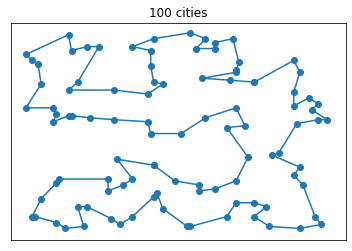

In [18]:
import matplotlib.pyplot as plt
tour.append(tour[0])
visualize_points(x_c, y_c, "{} cities".format(n), tour=tour)